# Odor Strength Prediction: Model Training, Validation & Insights

This notebook provides a the training, hyperparameter optimization, validation and interpretation of machine learning models for predicting odor strength from molecular structures. It includes:

1. **Load Dataset**: Examination of the curated odor strength dataset
2. **Model Training**: Hyperparameter optimization for various encoder-predictor combinations
3. **Performance Evaluation**: Comparison of direct (directly predicting odor strength) vs. indirect (first predicting presence of odor, then strength for odorous molecules) prediction approaches and several combinations of different molecular representations and predictive algorithms
4. **Feature Importance**: SHAP analysis to understand model predictions
5. **External Validation**: Testing on independent Keller 2016 dataset

In [1]:
# tested with python==3.12.2

In [2]:
import pandas as pd

## Load Dataset

Run the notebook dataset_curation.ipynb or python script dataset_curation.py first

In [32]:
df_odor_strength = pd.read_csv('data/df_odor_strength.csv')
groups = pd.read_csv('data/odor_strength_groups.csv', index_col=0).values.flatten()

### Dataset Analysis

#### see additional notebook dataset_analysis.ipynb

## Model Training with Hyperparameter optimization

In [4]:
from typing import Callable, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState
import os


from models.odor_strength_module import OdorStrengthModule, OdorStrengthModuleHyperparameterOptimizationWrapper
from models.predictors import Average, LogisticRegressionPredictor, RandomForestPredictor, XGBoostPredictor, MLP_Predictor, ChemPropMPNNPredictor, ChemeleonPredictor, CoralPredictor
from models.molecule_encoder import NativeEncoder, MorganFp, RDKitFp, TopologicalTorsionFp, AtomPairFp, MACCSKeysFp, RDKitDescriptors, ChemBerta

from hyperparameter_optimization.hyperparameter_optimizer import HyperparameterOptimizer
from hyperparameter_optimization.hyperparameter_spaces import HyperparameterSpaces
from utility.metrics import Metrics
from utility.stratified_group_split import stratified_group_train_test_split

hyperparameter_spaces = HyperparameterSpaces()

STORAGE_FOLDER = 'sqlite:///hyperparameter_optimization/hp_opt_dbs/'
if not os.path.exists('hyperparameter_optimization/hp_opt_dbs/'):
    os.makedirs('hyperparameter_optimization/hp_opt_dbs/')

/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X = df_odor_strength['canonical_smiles'].values
y = df_odor_strength['numerical_strength'].values
X_train, _, y_train, _, groups_train, _ = stratified_group_train_test_split(X, y, groups, random_state=42)
X_train = X_train.tolist()

### Example Model Cross Validation

In [ ]:
odor_strength_module = OdorStrengthModule(
    molecule_encoder=MorganFp(),
    odor_strength_predictor=RandomForestPredictor()
)

odor_strength_module.evaluate_kFold(X_train, y_train, groups=groups_train, n_splits=5, metric=Metrics().calculate_mse_macro, plot=True, show_wrong_pred=False)

### Hyperparameter Optimization

In [ ]:
N_REPEATS = 10
N_FOLDS = 10
N_TRIALS = 1
LIMIT = 100

callback = MaxTrialsCallback(
    n_trials=LIMIT,
    states=(TrialState.COMPLETE, TrialState.PRUNED),
)

class OdorStrengthHyperparameterOptimizer:
    """
    A hyperparameter optimizer specifically designed for odor strength prediction models.
    
    This class provides a structured approach to hyperparameter optimization for combinations
    of molecular encoders and odor strength predictors using Optuna optimization framework.
    
    Attributes:
        encoder (object): Molecular encoder class to use for molecule representation
        predictor (object): Predictor class to use for odor strength prediction
        n_trials (int): Number of optimization trials to run
        evaluation_metric (Callable): Metric function to optimize
        groups (np.ndarray): Group labels for stratified cross-validation
        n_cv_splits (int): Number of cross-validation splits
        n_cv_repeats (int): Number of cross-validation repeats
        load_if_exists (bool): Whether to load existing study if available
        predictor_hyperparameter_space_name_prefix (str): Prefix for hyperparameter space function names
    """
    
    def __init__(
            self,
            encoder: object,
            predictor: object,
            n_trials: int,
            evaluation_metric: Callable[[np.ndarray, np.ndarray], float],
            groups: np.ndarray = groups,
            n_cv_splits: int = 5,
            n_cv_repeats: int = 5,
            load_if_exists: bool = True,
            predictor_hyperparameter_space_name_prefix: str = 'hyperparameter_space_'
            ) -> None:
        """
        Initialize the hyperparameter optimizer.
        
        Args:
            encoder: Molecular encoder class for molecular representation
            predictor: Predictor class for odor strength prediction
            n_trials: Number of optimization trials to perform
            evaluation_metric: Function to evaluate model performance
            groups: Group labels for stratified cross-validation splits
            n_cv_splits: Number of cross-validation folds (default: 5)
            n_cv_repeats: Number of cross-validation repetitions (default: 5)
            load_if_exists: Whether to resume existing optimization study (default: True)
            predictor_hyperparameter_space_name_prefix: Prefix for hyperparameter space function names
        """
        self.encoder = encoder
        self.predictor = predictor
        self.n_trials = n_trials
        self.load_if_exists = load_if_exists
        self.evaluation_metric = evaluation_metric
        self.groups = groups
        self.n_cv_splits = n_cv_splits
        self.n_cv_repeats = n_cv_repeats
        self.predictor_hyperparameter_space_name_prefix = predictor_hyperparameter_space_name_prefix

    def evaluation_function(self, odor_strength_module: object, X: list[str], y: np.ndarray) -> tuple[float, dict]:
        """
        Evaluate the performance of an odor strength module using cross-validation.
        
        Args:
            odor_strength_module: Configured odor strength prediction module
            X: List of molecular SMILES strings
            y: Target values (numeric odor strength labels)
            
        Returns:
            tuple: Mean performance score and detailed evaluation results
        """
        evaluation_result = odor_strength_module.evaluate_kFold(X, y, metric=self.evaluation_metric, n_splits=self.n_cv_splits, n_repeats=self.n_cv_repeats, real_time_evaluation=True, groups=self.groups)
        return evaluation_result[0], evaluation_result[3]


    def hyperparameter_space(self, trial: optuna.trial.Trial) -> dict[str, Any]:
        """
        Define the hyperparameter search space for encoder-predictor combinations.
        
        Args:
            trial: Optuna trial object for hyperparameter sampling
            
        Returns:
            dict: Dictionary containing encoder and predictor hyperparameters
        """
        hyperparameters = {
            'encoder_name': self.encoder.__name__,
            'predictor_name': self.predictor.__name__,
        }
        encoder_function = getattr(hyperparameter_spaces, 'hyperparameter_space_' + self.encoder.__name__)
        hyperparameters['hp_molecule_encoder'] = encoder_function(trial)
        predictor_function = getattr(hyperparameter_spaces, self.predictor_hyperparameter_space_name_prefix + self.predictor.__name__)
        hyperparameters['hp_odor_strength_predictor'] = predictor_function(trial)
        return hyperparameters

    def optimize_study(
            self,
            X: list[str],
            y: np.ndarray,
            direction: str,
            study_name: str,
            storage_path: str,
            pruner: optuna.pruners.BasePruner,
            pruner_tolerance: float,
            n_repeats: int,
            **optimize_kwargs
            ) -> optuna.Study:
        """
        Run hyperparameter optimization study.
        
        Args:
            X: List of molecular SMILES strings for training
            y: Target values for training
            direction: Optimization direction ('minimize' or 'maximize')
            study_name: Name for the optimization study
            storage_path: Path to store optimization results
            pruner: Optuna pruner for early stopping of unpromising trials
            pruner_tolerance: Tolerance threshold for not pruning trials to the best-performing trial
            n_repeats: Number of evaluation repeats for robustness
            **optimize_kwargs: Additional arguments for optimization
            
        Returns:
            optuna.Study: Completed optimization study object
        """
        study = optuna.create_study(
            direction=direction,
            study_name=study_name,
            storage=storage_path,
            load_if_exists=self.load_if_exists,
            pruner=pruner
        )
        hp_opt = HyperparameterOptimizer(OdorStrengthModuleHyperparameterOptimizationWrapper, study)
        hp_opt.optimize(
            X,
            y,
            hyperparameter_space=self.hyperparameter_space,
            evaluation_function=self.evaluation_function,
            n_trials=self.n_trials,
            n_repeats=n_repeats,
            pruner_tolerance=pruner_tolerance,
            **optimize_kwargs
        )
        return study

encoders = [
    NativeEncoder,
    RDKitDescriptors,
    MorganFp,
    RDKitFp,
    TopologicalTorsionFp,
    AtomPairFp,
    MACCSKeysFp,
    ChemBerta
]
predictors = [
    RandomForestPredictor,
    XGBoostPredictor,
    MLP_Predictor,
    LogisticRegressionPredictor,
    CoralPredictor,
    ChemPropMPNNPredictor,
    ChemeleonPredictor,
    ]

### Hyperparameter Optimization Functions

Models for the following steps were optimized:

1. **Direct Approach**: Directly predict odor strength values (0-3 scale)
2. **Indirect First Step**: Predict odor presence/absence (binary classification)
3. **Indirect Second Step**: Predict strength for odorous molecules only (regression on subset (1-3 scale))

In [ ]:
def compatibility_check(encoder_name: str, predictor_name: str, w_regression: bool = True) -> bool:
    """
    Check compatibility between molecular encoders and predictors.
    
    Some predictors require specific types of input features. This function ensures
    that incompatible combinations are skipped during optimization.
    
    Args:
        encoder_name (str): Name of the molecular encoder
        predictor_name (str): Name of the predictor model
        w_regression (bool): Whether regression predictors should be included
        
    Returns:
        bool: True if the combination is compatible, False otherwise
    """
    check_list = ['Average', 'ChemPropMPNNPredictor', 'ChemeleonPredictor']
    check_1 = (encoder_name == 'NativeEncoder' and predictor_name not in check_list)
    check_2 = (encoder_name != 'NativeEncoder' and predictor_name in check_list)
    if  check_1 or check_2:
        print(f'Skipping {encoder_name} with {predictor_name} due to incompatibility.')
        return False
    elif not w_regression and predictor_name == 'CoralPredictor':
        return False
    return True

def optimize_hyperparameters_direct_approach(encoder: object, predictor: object) -> None:
    """
    Optimize hyperparameters using direct odor strength prediction approach.
    
    The encoder-predictor models directly predicts odor strength values (0-3 scale) from SMILES strings.
    
    Args:
        encoder (object): Molecular encoder class for molecular representation
        predictor (object): Predictor class for odor strength prediction
    """
    X = df_odor_strength['canonical_smiles'].values
    y = df_odor_strength['numerical_strength'].values
    X_train, _, y_train, _, groups_train, _ = stratified_group_train_test_split(X, y, groups, random_state=42)
    X_train = X_train.tolist()
    try:
        encoder_name = encoder.__name__
        predictor_name = predictor.__name__
        if compatibility_check(encoder_name, predictor_name, w_regression=True):
            print(f'Optimizing hyperparameters: {encoder_name} with {predictor_name}')
            OdorStrengthHyperparameterOptimizer(
                encoder,
                predictor,
                n_trials=N_TRIALS,
                evaluation_metric=Metrics().calculate_mse_macro,
                groups=groups_train,
                n_cv_splits=N_FOLDS,
                n_cv_repeats=1,
                load_if_exists=True,
                predictor_hyperparameter_space_name_prefix='hyperparameter_space_'
                ).optimize_study(
                    X=X_train,
                    y=y_train,
                    direction='minimize',
                    study_name=f'{encoder.__name__}_{predictor.__name__}_direct',
                    storage_path=STORAGE_FOLDER + f'{encoder.__name__}_{predictor.__name__}_direct.db',
                    pruner=optuna.pruners.PercentilePruner(25, n_startup_trials=3),
                    pruner_tolerance=0.02,
                    n_repeats=N_REPEATS,
                    callbacks=[callback]
                    )
    except Exception as e:
        print(f'Error with {encoder_name} and {predictor_name}. Error {e} Skipping...')


def optimize_hyperparameters_indirect_approach_first_step(encoder: object, predictor: object) -> None:
    """
    Optimize hyperparameters for the first step of indirect approach: odor detection.
    
    This function optimizes encoder-predictor models for binary classification to predict whether
    a molecule has any detectable odor (has_odor: 0 or 1).
    
    Args:
        encoder (object): Molecular encoder class for molecular representation
        predictor (object): Binary classifier for odor detection
    """
    X = df_odor_strength['canonical_smiles'].values
    y = df_odor_strength['has_odor'].values
    stratify_data = df_odor_strength['numerical_strength'].values
    X_train, _, y_train, _, groups_train, _ = stratified_group_train_test_split(X, y, groups, random_state=42, stratify_data=stratify_data)
    X_train = X_train.tolist()
    try:
        encoder_name = encoder.__name__
        predictor_name = predictor.__name__
        if compatibility_check(encoder_name, predictor_name, w_regression=False):
            print(f'Optimizing hyperparameters: {encoder_name} with {predictor_name}')
            OdorStrengthHyperparameterOptimizer(
                encoder,
                predictor,
                n_trials=N_TRIALS,
                evaluation_metric=Metrics().calculate_f1_score,
                groups=groups_train,
                n_cv_splits=N_FOLDS,
                n_cv_repeats=1,
                load_if_exists=True,
                predictor_hyperparameter_space_name_prefix='hyperparameter_space_binary_'
                ).optimize_study(
                    X=X_train,
                    y=y_train,
                    direction='maximize',
                    study_name=f'{encoder.__name__}_{predictor.__name__}_indirect_first_step',
                    storage_path=STORAGE_FOLDER + f'{encoder.__name__}_{predictor.__name__}_indirect_first_step.db',
                    pruner=optuna.pruners.PercentilePruner(25, n_startup_trials=3),
                    pruner_tolerance=0.015,
                    n_repeats=N_REPEATS,
                    callbacks=[callback]
                    )
    except Exception as e:
        print(f'Error with {encoder_name} and {predictor_name}. Error {e} Skipping...')


def optimize_hyperparameters_indirect_approach_second_step(encoder: object, predictor: object) -> None:
    """
    Optimize hyperparameters for the second step of indirect approach: odor strength prediction.
    
    This function optimizes encoder-predictor models for regression to predict odor strength (1-3 scale)
    for molecules that are odorous.
    
    Args:
        encoder (object): Molecular encoder class for molecular representation
        predictor (object): Regression model for odor strength prediction
    """
    X = df_odor_strength['canonical_smiles'].values
    y = df_odor_strength['numerical_strength'].values
    X_train, _, y_train, _, groups_train, _ = stratified_group_train_test_split(X, y, groups, random_state=42)
    X_train = X_train[y_train >= 1]
    groups_train = groups_train[y_train >= 1]
    y_train = y_train[y_train >= 1]
    X_train = X_train.tolist()
    try:
        encoder_name = encoder.__name__
        predictor_name = predictor.__name__
        if compatibility_check(encoder_name, predictor_name, w_regression=True):
            print(f'Optimizing hyperparameters: {encoder_name} with {predictor_name}')
            OdorStrengthHyperparameterOptimizer(
                encoder,
                predictor,
                n_trials=N_TRIALS,
                evaluation_metric=Metrics().calculate_mse_macro,
                groups=groups_train,
                n_cv_splits=N_FOLDS,
                n_cv_repeats=1,
                load_if_exists=True,
                predictor_hyperparameter_space_name_prefix='hyperparameter_space_'
                ).optimize_study(
                    X=X_train,
                    y=y_train,
                    direction='minimize',
                    study_name=f'{encoder.__name__}_{predictor.__name__}_indirect_second_step',
                    storage_path=STORAGE_FOLDER + f'{encoder.__name__}_{predictor.__name__}_indirect_second_step.db',
                    pruner=optuna.pruners.PercentilePruner(25, n_startup_trials=3),
                    pruner_tolerance=0.02,
                    n_repeats=N_REPEATS,
                    callbacks=[callback]
                    )
    except Exception as e:
        print(f'Error with {encoder_name} and {predictor_name}. Error {e} Skipping...')
              
for encoder in encoders:
    for predictor in predictors:
        optimize_hyperparameters_direct_approach(encoder, predictor)
        optimize_hyperparameters_indirect_approach_first_step(encoder, predictor)
        optimize_hyperparameters_indirect_approach_second_step(encoder, predictor)
print('Hyperparameter optimization completed for all combinations of encoders and predictors.')

## Best-Performing Model Training and Evaluation

In [7]:
from typing import Tuple
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import optuna

from utility.colors import okabe_ito
from models.predictors import Average, LogisticRegressionPredictor, RandomForestPredictor, XGBoostPredictor, MLP_Predictor, ChemPropMPNNPredictor, ChemeleonPredictor, CoralPredictor
from models.molecule_encoder import NativeEncoder, MorganFp, RDKitFp, TopologicalTorsionFp, AtomPairFp, MACCSKeysFp, RDKitDescriptors, ChemBerta
from hyperparameter_optimization.hyperparameter_optimizer import HyperparameterOptimizer
from models.odor_strength_module import OdorStrengthModule, OdorStrengthModuleHyperparameterOptimizationWrapper



DPI = 600
FONTSIZE = 8
LABELSIZE = 5
LABELPAD = 3
FIGURE_WIDTH = 8.3 / 2.54

STORAGE_FOLDER = 'sqlite:///hyperparameter_optimization/hp_opt_dbs/'

encoders = [
    NativeEncoder,
    RDKitDescriptors,
    MorganFp,
    RDKitFp,
    TopologicalTorsionFp,
    AtomPairFp,
    MACCSKeysFp,
    ChemBerta
]
predictors = [
    RandomForestPredictor,
    XGBoostPredictor,
    MLP_Predictor,
    LogisticRegressionPredictor,
    CoralPredictor,
    ChemPropMPNNPredictor,
    ChemeleonPredictor,
    ]

X = df_odor_strength['canonical_smiles'].values
y = df_odor_strength['numerical_strength'].values
X_train, X_test, y_train, y_test, groups_train, groups_test = stratified_group_train_test_split(X, y, groups, random_state=42)
X_train = X_train.tolist()
X_test = X_test.tolist()

### Performance Evaluation Functions

This section contains functions for evaluating the best-performing models from hyperparameter optimization and generating performance visualizations.

In [8]:
def predict_on_test_set(
        model_class: OdorStrengthModuleHyperparameterOptimizationWrapper,
        hyperparameters: dict[str, Any],
        X_train: list[str],
        y_train: np.ndarray,
        X_test: list[str],
        y_test: np.ndarray,
        repeats: int = 10
        ) -> pd.DataFrame:
    """
    Generate predictions on the test set with multiple random initializations.
    
    This function trains the same model multiple times with different random seeds
    to assess prediction robustness and provide uncertainty estimates.
    
    Args:
        model_class: Class of the model to instantiate
        hyperparameters (dict): Hyperparameters for model initialization
        X_train (list): Training molecular SMILES strings
        y_train (np.ndarray): Training target values
        X_test (list): Test molecular SMILES strings
        y_test (np.ndarray): Test target values
        repeats (int): Number of training/prediction repeats (default: 10)
        
    Returns:
        pd.DataFrame: DataFrame with repeated predictions and corresponding true values
    """
    preds_list = []
    for i in range(repeats):
        model = model_class(**hyperparameters)
        # print('model initiated for prediction run', i+1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds_list.append(preds)
    preds = np.hstack(preds_list)
    y_test_stacked = np.hstack([y_test]*repeats)
    df = pd.DataFrame({'y_test': y_test_stacked, 'preds': preds})
    return df


def get_best_model_performances(
        encoders: list[object],
        predictors: list[object],
        study_name_suffix: str,
        storage_path_suffix: str,
        direction: str,
        metric: Callable[[np.ndarray, np.ndarray], float],
        X_train: list[str],
        y_train: np.ndarray,
        X_test: list[str],
        y_test: np.ndarray,
        repeats: int = 10,
        save_path_addition: str = '',
        additional_test_set: tuple[list[str], np.ndarray] | None = None
        ) -> tuple[pd.DataFrame, type, dict[str, Any]]:
    """
    Evaluate the best models from hyperparameter optimization studies.
    
    This function loads optimized hyperparameter configurations from storage, evaluates them on test data,
    and creates a performance matrix comparing all encoder-predictor combinations.
    
    Args:
        encoders (list): List of molecular encoder classes
        predictors (list): List of predictor classes
        study_name_suffix (str): Suffix for study names to load
        storage_path_suffix (str): Suffix for storage paths to load
        direction (str): Optimization direction ('minimize' or 'maximize')
        metric (callable): Evaluation metric function
        X_train (list): Training molecular SMILES strings
        y_train (np.ndarray): Training target values
        X_test (list): Test molecular SMILES strings  
        y_test (np.ndarray): Test target values
        repeats (int): Number of evaluation repeats (default: 10)
        save_path_addition (str): Additional path component for saving predictions
        additional_test_set (tuple, optional): Additional test set (X, y) for evaluation
        
    Returns:
        tuple: Performance DataFrame, best model class, best hyperparameters
    """
    encoder_name_list = [encoder.__name__ for encoder in encoders]
    predictor_name_list = [predictor.__name__ for predictor in predictors]
    df = pd.DataFrame(columns=encoder_name_list, index=predictor_name_list)
    models = {}
    hyperparameters = {}
    for encoder in encoders:
        for predictor in predictors:
            study_name=f'{encoder.__name__}_{predictor.__name__}_' + study_name_suffix
            storage_path=f'{STORAGE_FOLDER}{encoder.__name__}_{predictor.__name__}_' + storage_path_suffix + '.db'
            try:
                if not os.path.exists(storage_path.replace('sqlite:///', '')):
                    storage_path = optuna.storages.JournalStorage(
                        optuna.storages.journal.JournalFileBackend(
                            STORAGE_FOLDER.replace('sqlite:///', '') + f'{encoder.__name__}_{predictor.__name__}_' + storage_path_suffix + '.log'
                        )
                    )   
                study = optuna.load_study(
                    study_name=study_name,
                    storage=storage_path
                )
                complete_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
                print(f'{storage_path_suffix} {encoder.__name__} {predictor.__name__} Number of complete trials: {len(complete_trials)}')
                hp_opt = HyperparameterOptimizer(OdorStrengthModuleHyperparameterOptimizationWrapper, study)
                if encoder.__name__ not in models:
                    models[encoder.__name__] = {}
                models[encoder.__name__][predictor.__name__] = hp_opt.model
                if encoder.__name__ not in hyperparameters:
                    hyperparameters[encoder.__name__] = {}
                hyperparameters[encoder.__name__][predictor.__name__] = hp_opt.get_best_hyperparameters()
                if not os.path.exists('test_predictions/'):
                    os.makedirs('test_predictions/')
                if not os.path.exists('test_predictions/' + save_path_addition + encoder.__name__ + predictor.__name__ + '_predictions.csv'):
                    print('path not found, predicting on test set:', 'test_predictions/' + encoder.__name__ + predictor.__name__ + '_predictions.csv')
                    df_pred = predict_on_test_set(hp_opt.model, hp_opt.get_best_hyperparameters(), X_train, y_train, X_test, y_test, repeats=repeats)
                    df_pred.to_csv('test_predictions/' + save_path_addition + encoder.__name__ + predictor.__name__ + '_predictions.csv')
                    print('saved successfully')
                    if additional_test_set is not None:
                        X_test_additional, y_test_additional = additional_test_set
                        df_pred_additional = predict_on_test_set(hp_opt.model, hp_opt.get_best_hyperparameters(), X_train, y_train, X_test_additional, y_test_additional, repeats=repeats)
                        df_pred_additional.to_csv('test_predictions/' + save_path_addition + encoder.__name__ + predictor.__name__ + '_predictions_additional.csv')
                        print('saved additional test set successfully')
                else:
                    df_pred = pd.read_csv('test_predictions/' + save_path_addition + encoder.__name__ + predictor.__name__ + '_predictions.csv', index_col=0)
                best_value_runs = []
                for i in range(repeats):
                    df_pred_subset = df_pred.iloc[i*len(y_test):(i+1)*len(y_test)]
                    best_values = metric(df_pred_subset['y_test'].values, df_pred_subset['preds'].values)
                    if isinstance(best_values, (list, tuple)):
                        best_value = best_values[0]
                    else:
                        best_value = best_values
                    best_value_runs.append(best_value)
                best_value = np.mean(best_value_runs)
                print('Standard deviation over runs for ' + encoder.__name__ + predictor.__name__, np.std(best_value_runs))
                print(f'Best value for {study_name}: {best_value}')
                df.loc[predictor.__name__, encoder.__name__] = best_value
            except Exception as e:
                print(f"Error loading study {study_name}: {e}")
                best_value = None
    df = df.astype(float)
    df[df<0] = np.nan
    if direction == 'maximize':
        best_position = np.unravel_index(df.fillna(-np.inf).values.argmax(), df.shape)
    elif direction == 'minimize':
        best_position = np.unravel_index(df.fillna(np.inf).values.argmin(), df.shape)
    else:
        raise ValueError("Direction must be 'maximize' or 'minimize'")
    row_label = df.index[best_position[0]]
    col_label = df.columns[best_position[1]]
    best_model = models[col_label][row_label]
    best_hyperparameters = hyperparameters[col_label][row_label]
    return df, best_model, best_hyperparameters


encoders = [
    NativeEncoder,
    RDKitDescriptors,
    MorganFp,
    RDKitFp,
    TopologicalTorsionFp,
    AtomPairFp,
    MACCSKeysFp,
    ChemBerta
]
predictors = [
    RandomForestPredictor,
    XGBoostPredictor,
    MLP_Predictor,
    LogisticRegressionPredictor,
    CoralPredictor,
    ChemPropMPNNPredictor,
    ChemeleonPredictor,
    ]

y_train_has_odor = y_train.copy()
y_train_has_odor[y_train_has_odor>0] = 1
y_test_has_odor = y_test.copy()
y_test_has_odor[y_test_has_odor>0] = 1
X_train_wo_odorless = np.array(X_train)[np.array(y_train)>0].tolist()
y_train_wo_odorless = y_train.copy()[np.array(y_train)>0]
X_test_wo_odorless = np.array(X_test)[np.array(y_test)>0].tolist()
y_test_wo_odorless = y_test.copy()[np.array(y_test)>0]

df_direct, best_model_direct_class, best_hyperparameters_direct = get_best_model_performances(
    encoders,
    predictors,
    'direct',
    'direct',
    direction='minimize',
    metric=Metrics().calculate_mse_macro,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    save_path_addition='direct'
    )
df_indirect_1, best_model_indirect_first_step_class, best_hyperparameters_indirect_first_step = get_best_model_performances(
    encoders,
    predictors,
    'indirect_first_step',
    'indirect_first_step',
    direction='maximize',
    metric=Metrics().calculate_f1_score,
    X_train=X_train, y_train=y_train_has_odor, X_test=X_test, y_test=y_test_has_odor,
    save_path_addition='indirect_1'
    )
df_indirect_2, best_model_indirect_second_step_class, best_hyperparameters_indirect_second_step = get_best_model_performances(
    encoders,
    predictors, 
    'indirect_second_step',
    'indirect_second_step',
     direction='minimize',
     metric=Metrics().calculate_mse_macro,
     X_train=X_train_wo_odorless, y_train=y_train_wo_odorless, X_test=X_test_wo_odorless, y_test=y_test_wo_odorless,
     save_path_addition='indirect_2',
     additional_test_set=(X_test, y_test)
     )

Error loading study NativeEncoder_RandomForestPredictor_direct: 'Record does not exist.'
Error loading study NativeEncoder_XGBoostPredictor_direct: 'Record does not exist.'
Error loading study NativeEncoder_MLP_Predictor_direct: 'Record does not exist.'
Error loading study NativeEncoder_LogisticRegressionPredictor_direct: 'Record does not exist.'
Error loading study NativeEncoder_CoralPredictor_direct: 'Record does not exist.'
direct NativeEncoder ChemPropMPNNPredictor Number of complete trials: 3
Standard deviation over runs for NativeEncoderChemPropMPNNPredictor 0.13979861163569898
Best value for NativeEncoder_ChemPropMPNNPredictor_direct: 1.3834653238890993
direct NativeEncoder ChemeleonPredictor Number of complete trials: 3
Standard deviation over runs for NativeEncoderChemeleonPredictor 0.0009493670886076001
Best value for NativeEncoder_ChemeleonPredictor_direct: 1.5222637720470689
direct RDKitDescriptors RandomForestPredictor Number of complete trials: 3
Standard deviation over r

### Indirect Approach: Combining Two-Step Predictions

This section combines the predictions from the two-step indirect approach:
1. First model predicts if a molecule has any odor (binary classification)
2. Second model predicts odor strength for molecules classified as odorous (regression)

In [9]:
repeats = 10
y_test_stack = np.hstack([y_test]*repeats)
save_path_addition_1 = 'indirect_1'
save_path_addition_2 = 'indirect_2'
mse_macros = {encoder.__name__: {} for encoder in encoders}

for encoder in encoders:
    for predictor in predictors:
        try:
            df_pred_1 = pd.read_csv('test_predictions/' + save_path_addition_1 + encoder.__name__ + predictor.__name__ + '_predictions.csv', index_col=0)
            df_pred_2 = pd.read_csv('test_predictions/' + save_path_addition_2 + encoder.__name__ + predictor.__name__ + '_predictions_additional.csv', index_col=0)
            df_pred_combined = df_pred_2.copy()
            df_pred_combined.loc[df_pred_1['preds'] < 0.5, 'preds'] = df_pred_1.loc[df_pred_1['preds'] < 0.5, 'preds']
            mse_macros[encoder.__name__][predictor.__name__] = Metrics().calculate_mse_macro(y_test_stack, df_pred_combined['preds'].values)[0]
        except Exception as e:
            print(f"Error processing predictions for {encoder.__name__} {predictor.__name__}: {e}")
            continue
df_odor_strength_indirect = pd.DataFrame(mse_macros)

Error processing predictions for NativeEncoder RandomForestPredictor: [Errno 2] No such file or directory: 'test_predictions/indirect_1NativeEncoderRandomForestPredictor_predictions.csv'
Error processing predictions for NativeEncoder XGBoostPredictor: [Errno 2] No such file or directory: 'test_predictions/indirect_1NativeEncoderXGBoostPredictor_predictions.csv'
Error processing predictions for NativeEncoder MLP_Predictor: [Errno 2] No such file or directory: 'test_predictions/indirect_1NativeEncoderMLP_Predictor_predictions.csv'
Error processing predictions for NativeEncoder LogisticRegressionPredictor: [Errno 2] No such file or directory: 'test_predictions/indirect_1NativeEncoderLogisticRegressionPredictor_predictions.csv'
Error processing predictions for NativeEncoder CoralPredictor: [Errno 2] No such file or directory: 'test_predictions/indirect_1NativeEncoderCoralPredictor_predictions.csv'
Error processing predictions for RDKitDescriptors CoralPredictor: [Errno 2] No such file or d

/tmp/ipykernel_2458039/436994745.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0214655  0.15497899 0.42340115 ... 0.39543015 0.19465876 0.10789099]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pred_combined.loc[df_pred_1['preds'] < 0.5, 'preds'] = df_pred_1.loc[df_pred_1['preds'] < 0.5, 'preds']
/tmp/ipykernel_2458039/436994745.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15857534 0.48308653 0.04563081 ... 0.17352466 0.44324306 0.20341057]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pred_combined.loc[df_pred_1['preds'] < 0.5, 'preds'] = df_pred_1.loc[df_pred_1['preds'] < 0.5, 'preds']
/tmp/ipykernel_2458039/436994745.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

In [10]:
df_odor_strength_indirect

,NativeEncoder,RDKitDescriptors,MorganFp,RDKitFp,TopologicalTorsionFp,AtomPairFp,MACCSKeysFp,ChemBerta
ChemPropMPNNPredictor,1.505728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChemeleonPredictor,1.615686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RandomForestPredictor,NaN,1.028267,1.526526,1.660991,2.393759,1.917909,1.238698,1.554230
XGBoostPredictor,NaN,0.700205,1.422953,1.091419,1.656300,0.997770,1.380852,1.167920
MLP_Predictor,NaN,3.500000,1.509470,3.500000,1.534856,2.298734,3.500000,3.500000
LogisticRegressionPredictor,NaN,1.161750,1.561300,0.877414,1.476194,1.329434,0.936539,1.364194


### Heatmap Visualization


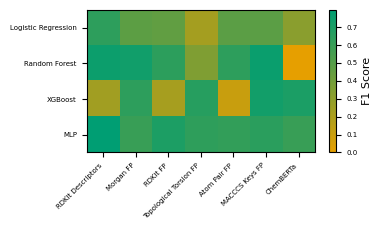

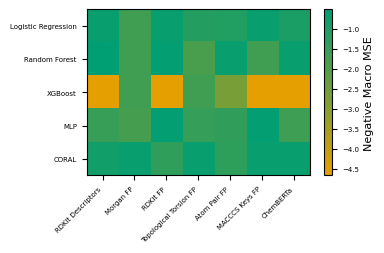

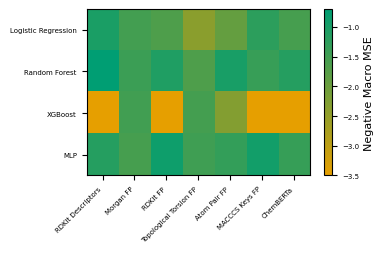

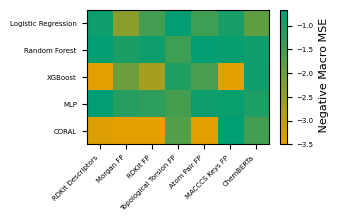

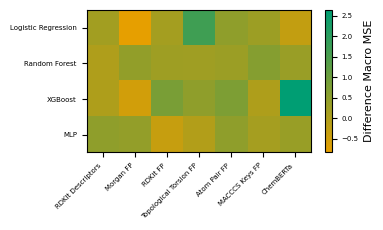

In [11]:
from typing import Tuple
DPI = 600
colors = [okabe_ito[1], okabe_ito[3]]
mycmap = LinearSegmentedColormap.from_list("mycmap", colors, N=256)
width_factor = np.sqrt(2.45/2.2)


def plot_heatmap(
        df: pd.DataFrame,
        colorbar_label: str,
        figsize: Tuple[int, int] = (10, 10),
        fontsize: int = 12,
        labelsize: int = 12,
        labelpad: int = 10,
        dpi: int = 100,
        save_path: list[str] | None = None,
        custom_x_ticks: list[str] | None = None,
        custom_y_ticks: list[str] | None = None,
) -> None:
    """
    Create a performance heatmap for encoder-predictor combinations.
    
    This function visualizes model performance across different combinations of
    molecular encoders and predictors using a color-coded heatmap.
    
    Args:
        df (pd.DataFrame): Performance matrix with predictors as rows and encoders as columns
        colorbar_label (str): Label for the colorbar indicating the performance metric
        figsize (Tuple[int, int]): Figure size in inches (width, height)
        fontsize (int): Font size for labels and titles
        labelsize (int): Font size for tick labels
        labelpad (int): Padding for axis labels
        dpi (int): Resolution for saved figures
        save_path (list[str], optional): List of file paths to save the figure
        custom_x_ticks (list[str], optional): Custom labels for x-axis (encoders)
        custom_y_ticks (list[str], optional): Custom labels for y-axis (predictors)
    """
    plt.figure(figsize=figsize)
    plt.imshow(df, cmap=mycmap, aspect='auto')
    colorbar = plt.colorbar()
    colorbar.set_label(colorbar_label, fontsize=fontsize, labelpad=labelpad+labelpad*0.2)
    colorbar.ax.tick_params(labelsize=labelsize)
    # plt.xlabel('Encoders', fontsize=fontsize, labelpad=labelpad)
    # plt.ylabel('Predictors', fontsize=fontsize, labelpad=labelpad)
    if custom_x_ticks is None:
        custom_x_ticks = [label.replace('Encoder', '') for label in df.columns]
    plt.xticks(ticks=range(len(custom_x_ticks)), labels=custom_x_ticks, rotation=45, ha='right')
    if custom_y_ticks is None:
        custom_y_ticks = [label.split('Predictor')[0] for label in df.index]
    plt.yticks(ticks=range(len(df.index)), labels=custom_y_ticks)
    plt.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.tight_layout()
    if save_path is not None:
        for path in save_path:
            plt.savefig(path, dpi=dpi, bbox_inches='tight')
    plt.show()


plot_heatmap(
    df_indirect_1.dropna(how='all').iloc[:4, 1:],
    colorbar_label='F1 Score',
    figsize=(FIGURE_WIDTH*1.2, 2*1.2),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    save_path=['figures/hp_opt_heatmap_has_odor.pdf'],
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']
    )
plot_heatmap(
    - df_indirect_2.dropna(how='all').iloc[:5, 1:],
    colorbar_label='Negative Macro MSE',
    figsize=(FIGURE_WIDTH*1.2, 2.2*1.2),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    save_path=['figures/hp_opt_heatmap_wo_odorless.pdf'],
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP', 'CORAL']
    )
plot_heatmap(
    - df_odor_strength_indirect.dropna(how='all').iloc[2:, 1:],
    colorbar_label='Negative Macro MSE',
    figsize=(FIGURE_WIDTH*1.2, 2.2*1.2),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    save_path=['figures/hp_opt_heatmap_indirect.pdf'],
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']
    )
# 
plot_heatmap(
    - df_direct.dropna(how='all').iloc[:5, 1:],
    colorbar_label=' Negative Macro MSE',
    figsize=(FIGURE_WIDTH*width_factor, 2.2*width_factor),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    save_path=['figures/hp_opt_heatmap_w_odorless.pdf'],
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP', 'CORAL']
)
# difference heatmap
plot_heatmap(
    df_odor_strength_indirect.iloc[2:, 1:] - df_direct.dropna(how='all').iloc[:4, 1:],
    colorbar_label='Difference Macro MSE',
    figsize=(FIGURE_WIDTH*1.2, 2*1.2),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    save_path=['figures/hp_opt_heatmap_difference.pdf', 'figures/hp_opt_heatmap_difference.png'],
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']
)

### Model Comparison: Direct vs. Indirect Approaches

This section compares the best-performing models from both approaches on the test set to determine which strategy works better for odor strength prediction.

In [34]:
repeats = 10
preds_list = []
preds_two_step_list = []
X = df_odor_strength['canonical_smiles'].values
y = df_odor_strength['has_odor'].values
stratify_data = df_odor_strength['numerical_strength'].values
X_train, X_test, y_train, y_test, groups_train, groups_test = stratified_group_train_test_split(X, stratify_data, groups, random_state=42)
X_train = X_train.tolist()
X_test = X_test.tolist()


for i in range(repeats):
    model = best_model_direct_class(**best_hyperparameters_direct)
    model.fit(X_train, y_train)
#     model.save(
#     encoder_path='encoder.gz',
#     predictor_path='predictor.pth',
#     predictor_hyperparameter_path='predictor_hyperparameters.json',
#     config_path='model_config.txt',
# )
    preds = model.predict(X_test)
    preds_list.append(preds)


    indirect_first_step_model = best_model_indirect_first_step_class(**best_hyperparameters_indirect_first_step)
    indirect_second_step_model = best_model_indirect_second_step_class(**best_hyperparameters_indirect_second_step)
    

    y_train_has_odor = y_train.copy()
    y_train_has_odor[y_train_has_odor>0] = 1
    indirect_first_step_model.fit(X_train, y_train_has_odor)

    y_train_wo_odorless = y_train.copy()
    X_train_wo_odorless = np.array(X_train)[y_train_wo_odorless >= 1].tolist()
    y_train_wo_odorless = y_train_wo_odorless[y_train_wo_odorless >= 1]
    indirect_second_step_model.fit(X_train_wo_odorless, y_train_wo_odorless)

    preds_two_step = indirect_first_step_model.predict(X_test)
    preds_two_step[preds_two_step>0.5] = indirect_second_step_model.predict(np.array(X_test)[preds_two_step>0.5].tolist())
    preds_two_step_list.append(preds_two_step)

preds = np.hstack(preds_list)
preds_two_step = np.hstack(preds_two_step_list)
y_test = np.hstack([y_test]*repeats)

2056
Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using device: cuda


/home/pfichtelmann/Software/anaconda3/envs/odor_strength_code/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:02:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


(np.float64(0.6732477434737342), {np.int64(0): np.float64(0.5341772151898734), np.int64(1): np.float64(1.0982142857142858), np.int64(2): np.float64(0.25045454545454543), np.int64(3): np.float64(0.8101449275362319)}) 0.5063679245283019
Standard MSE Macro Deviation per repeat 0.02641868903378121
[np.float64(0.6651624895467768), np.float64(0.6607856714006962), np.float64(0.6638131898829477), np.float64(0.7024658736512066), np.float64(0.6872252529620444), np.float64(0.6131739797535064), np.float64(0.6543864226032634), np.float64(0.6878460880524722), np.float64(0.6905564063069566), np.float64(0.7070620605774706)]
0.4514741592803042
Standard R2 Deviation per repeat 0.027375049035511696


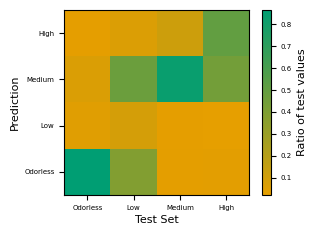

(np.float64(0.8967377158248099), {np.int64(0): np.float64(0.379746835443038), np.int64(1): np.float64(0.5892857142857143), np.int64(2): np.float64(0.5454545454545454), np.int64(3): np.float64(2.072463768115942)}) 0.7688679245283019
Standard MSE Macro Deviation per repeat 1.1102230246251565e-16
[np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099), np.float64(0.8967377158248099)]
0.1671195897781983
Standard R2 Deviation per repeat 0.0


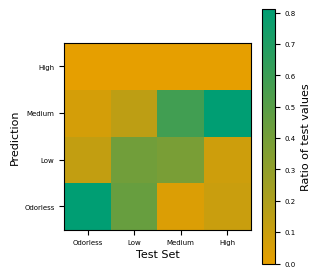

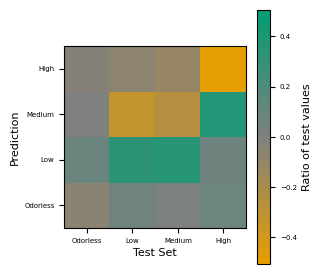

In [35]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from utility.colors import okabe_ito

def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_pred_2: np.ndarray|None = None, # for difference plotting
    figsize: tuple = (10, 10),
    dpi: int = 100,
    tick_labels: dict = {0: "Odorless", 1: "Low", 2: "Medium", 3: "High"},
    cmap: str|LinearSegmentedColormap = 'viridis',
    text_annotation: bool = True,
    fontsize: int = 20,
    labelsize: int = 18,
    labelpad: int = 10,
    save_path: str | None = None,
    center_value: float | None = None,
    ) -> None:
    """
    Plots a normalized (by true values) confusion matrix for classification results.

    Parameters
    ----------
    y_true : np.ndarray
        Array of true class labels.
    y_pred : np.ndarray
        Array of predicted class labels.
    figsize : tuple, optional
        Size of the figure in inches (width, height). Default is (10, 10).
    dpi : int, optional
        Dots per inch for the figure resolution. Default is 100.
    tick_labels : dict, optional
        Dictionary mapping class indices to label names for axis ticks. If prediction or true values are higher or lower than the keys in this dictionary, they will be set to the maximum or minimum key value, respectively.
        Default is {0: "None", 1: "Low", 2: "Medium", 3: "High"}.

    Returns
    -------
    None
        Displays the confusion matrix plot.
    """
    y_pred = y_pred.round().astype(int)
    y_true = y_true.round().astype(int)
    max_tick_value = max(tick_labels.keys())
    min_tick_value = min(tick_labels.keys())
    y_pred[y_pred > max_tick_value], y_pred[y_pred < min_tick_value] = max_tick_value, min_tick_value
    y_true[y_true > max_tick_value], y_true[y_true < min_tick_value] = max_tick_value, min_tick_value
    confusion = confusion_matrix(y_true, y_pred)
    confusion = confusion.T
    normed_confusion_matrix = confusion / np.sum(confusion, axis=0)
    if y_pred_2 is not None:
        y_pred_2 = y_pred_2.round().astype(int)
        y_pred_2[y_pred_2 > max_tick_value], y_pred_2[y_pred_2 < min_tick_value] = max_tick_value, min_tick_value
        confusion_2 = confusion_matrix(y_true, y_pred_2)
        confusion_2 = confusion_2.T
        normed_confusion_matrix_2 = confusion_2 / np.sum(confusion_2, axis=0)
        normed_confusion_matrix = normed_confusion_matrix_2 - normed_confusion_matrix
    fig, ax = plt.subplots(figsize=figsize)
    # Calculate vmin and vmax for centering colorbar
    if center_value is not None:
        data_min = normed_confusion_matrix.min()
        data_max = normed_confusion_matrix.max()
        max_abs_diff = max(abs(data_max - center_value), abs(data_min - center_value))
        vmin = center_value - max_abs_diff
        vmax = center_value + max_abs_diff
    else:
        vmin = None
        vmax = None
    im = ax.imshow(normed_confusion_matrix, cmap=cmap, aspect='equal', origin='lower', vmin=vmin, vmax=vmax)
    if text_annotation:
        for i in range(normed_confusion_matrix.shape[0]):
            for j in range(normed_confusion_matrix.shape[1]):
                text = ax.text(
                    j, i, f"{normed_confusion_matrix[i, j]:.2f}",
                    ha='center', va='center',
                    color='white' # if normed_confusion_matrix[i, j] < 0.5 else 'black'  # adjust for contrast
                )
    colorbar = plt.colorbar(im)
    colorbar.set_label('Ratio of test values', fontsize=fontsize, labelpad=labelpad+labelpad*0.2)
    colorbar.ax.tick_params(labelsize=labelsize)
    plt.xticks(list(tick_labels.keys()), list(tick_labels.values()))
    plt.yticks(list(tick_labels.keys()), list(tick_labels.values()))
    plt.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.xlabel('Test Set', fontsize=fontsize, labelpad=labelpad)
    plt.ylabel('Prediction', fontsize=fontsize, labelpad=labelpad)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

colors = [okabe_ito[1], okabe_ito[3]]
mycmap = LinearSegmentedColormap.from_list("mycmap", colors, N=256)

print(Metrics().calculate_mse_macro(y_test, preds), Metrics().calculate_mse(y_test, preds))
samples_per_repeat = int(y_test.shape[0]/repeats)
mse_macros = [Metrics().calculate_mse_macro(y_test[i*samples_per_repeat:(i+1)*samples_per_repeat], preds[i*samples_per_repeat:(i+1)*samples_per_repeat])[0] for i in range(repeats)]
print('Standard MSE Macro Deviation per repeat', np.std(mse_macros))
print(mse_macros)
print(Metrics().calculate_r2(y_test, preds))
r2s = [Metrics().calculate_r2(y_test[i*samples_per_repeat:(i+1)*samples_per_repeat], preds[i*samples_per_repeat:(i+1)*samples_per_repeat]) for i in range(repeats)]
print('Standard R2 Deviation per repeat', np.std(r2s))
plot_confusion_matrix(
    y_test,
    preds,
    cmap=mycmap,
    figsize=(FIGURE_WIDTH, 2.45),
    dpi=DPI,
    text_annotation=False,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    )

print(Metrics().calculate_mse_macro(y_test, preds_two_step), Metrics().calculate_mse(y_test, preds_two_step))
mse_macros_two_step = [Metrics().calculate_mse_macro(y_test[i*samples_per_repeat:(i+1)*samples_per_repeat], preds_two_step[i*samples_per_repeat:(i+1)*samples_per_repeat])[0] for i in range(repeats)]
print('Standard MSE Macro Deviation per repeat', np.std(mse_macros_two_step))
print(mse_macros_two_step)
print(Metrics().calculate_r2(y_test, preds_two_step))
r2s_two_step = [Metrics().calculate_r2(y_test[i*samples_per_repeat:(i+1)*samples_per_repeat], preds_two_step[i*samples_per_repeat:(i+1)*samples_per_repeat]) for i in range(repeats)]
print('Standard R2 Deviation per repeat', np.std(r2s_two_step))
plot_confusion_matrix(
    y_test,
    preds_two_step,
    cmap=mycmap,
    figsize=(FIGURE_WIDTH, 3),
    dpi=DPI,
    text_annotation=False,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
)

# difference plot
colors = [okabe_ito[1], '#808080', okabe_ito[3]]
mycmap3 = LinearSegmentedColormap.from_list("mycmap", colors, N=256)
plot_confusion_matrix(
    y_test,
    preds,
    y_pred_2=preds_two_step,
    cmap=mycmap3,
    figsize=(FIGURE_WIDTH, 3),
    dpi=DPI,
    text_annotation=False,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    center_value=0.0
)

## External Validation on Keller 2016 Dataset

This section validates the best-performing model on an independent dataset from Keller et al. (2016) to assess generalization performance.

In [36]:
from data.data_cleaner import GoodScentsDataCleaner
import pandas as pd

cleaned_keller_path = 'data/keller_2016/cleaned_keller_2016.csv'
if os.path.exists(cleaned_keller_path):
    keller_2016 = pd.read_csv(cleaned_keller_path)
else:
    keller_2016 = pd.read_excel('data/keller_2016/12868_2016_287_MOESM1_ESM.xlsx', header=2)
    keller_2016.rename(columns={'C.A.S.': 'cas'}, inplace=True)
    data_cleaner = GoodScentsDataCleaner(data=keller_2016)
    data_cleaner.clean_molecules()
    keller_2016 = data_cleaner.data
    keller_2016.to_csv(cleaned_keller_path, index=False)


In [ ]:
keller_2016 = keller_2016[keller_2016['canonical_smiles'].notna()]
keller_2016['predicted_intensity'] = model.predict(keller_2016['canonical_smiles'].tolist())
keller_2016['predicted_intensity_rounded'] = keller_2016['predicted_intensity'].round().astype(float)

In [38]:
keller_2016_test  = keller_2016[~keller_2016['canonical_smiles'].isin(df_odor_strength['canonical_smiles'])]
from tqdm import tqdm
def calculate_morgan_tanimoto_similarity(smiles_list_1: list[str], smiles_list_2: list[str]) -> pd.DataFrame:
    """
    Check for molecular similarity between training and external test sets.
    
    This function computes Tanimoto similarity coefficients using Morgan fingerprints
    to identify molecules in the external test set that are too similar to training
    molecules, which could lead to data leakage.
    
    Args:
        smiles_list_1 (list): SMILES strings from training dataset
        smiles_list_2 (list): SMILES strings from external test dataset
        
    Returns:
        pd.DataFrame: Similarity matrix with external molecules as rows and 
                     training molecules as columns
    """
    morgan_fingerprint = MorganFp(radius=3, fpSize=2048)
    morgan_fingerprints_1 = morgan_fingerprint.encode(smiles_list_1)
    morgan_fingerprints_2 = morgan_fingerprint.encode(smiles_list_2)
    # morgan_similarities = {smiles_1: np.sum(np.logical_and(np.array(morgan_fingerprints_2), fp1), axis=1) / len(fp1) for smiles_1, fp1 in tqdm(zip(smiles_list_1, morgan_fingerprints_1))}
    morgan_similarities = {smiles_1: np.sum(np.logical_and(np.array(morgan_fingerprints_2), fp1), axis=1) / np.sum(np.logical_or(np.array(morgan_fingerprints_2), fp1), axis=1) for smiles_1, fp1 in tqdm(zip(smiles_list_1, morgan_fingerprints_1))}

    # morgan_similarities = {smiles_2: [jaccard_score(fp1, fp2) for smiles_1, fp1 in zip(smiles_list_1, morgan_fingerprints_1)] for smiles_2, fp2 in tqdm(zip(smiles_list_2, morgan_fingerprints_2))}
    df_morgan_similarities = pd.DataFrame(morgan_similarities, index=smiles_list_2)
    return df_morgan_similarities
df_morgan_similarities = calculate_morgan_tanimoto_similarity(df_odor_strength['canonical_smiles'].tolist(), keller_2016_test['canonical_smiles'].unique().tolist())

2056it [00:01, 1691.19it/s]


In [39]:
smiles_to_remove = df_morgan_similarities[df_morgan_similarities.max(axis=1) > 0.8].index
keller_2016_test = keller_2016_test[~keller_2016_test['canonical_smiles'].isin(smiles_to_remove)]
keller_2016_test['canonical_smiles'].nunique()

152

In [40]:
keller_2016_test['Odor dilution'] = keller_2016_test['Odor dilution'].map({  
    '1/10': 0.1,
    '1/1,000': 0.001,
    '1/100,000': 0.00001,
    '1/10,000,000': 1e-07
}).astype(float)

/tmp/ipykernel_2458039/3163121000.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Number of compounds: 125


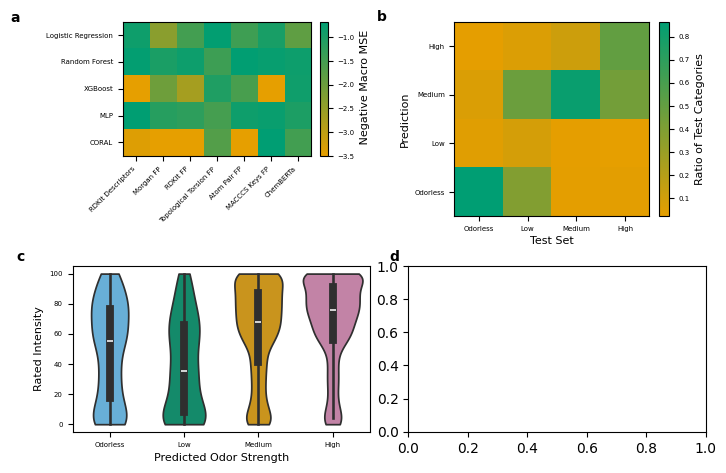

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from utility.colors import okabe_ito

FIGURE_WIDTH_LONG = 17.1 / 2.54

def plot_combined_figure_with_violins(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    df: pd.DataFrame,
    keller_data: pd.DataFrame,
    colorbar_label_1: str,
    colorbar_label_2: str,
    tick_labels: dict = {0: "Odorless", 1: "Low", 2: "Medium", 3: "High"},
    text_annotation: bool = True,
    custom_x_ticks: list[str] | None = None,
    custom_y_ticks: list[str] | None = None,
    figsize: tuple = (15, 18),
    dpi: int = 100,
    fontsize: int = 12,
    labelsize: int = 12,
    labelpad: int = 10,
    cmap: str|LinearSegmentedColormap = 'viridis',
    save_path: list[str] | None = None,
    width_ratios: list[float] = [1, 1, 1, 1, 1, 1],
    height_ratios: list[float] = [1, 1],
    hspace: float = 1
    ) -> plt.Figure:
    """
    Create a comprehensive multi-panel figure combining performance visualization.
    
    This function creates a complex figure with multiple subplots:
    - Top left: Performance heatmap across encoder-predictor combinations
    - Top right: Confusion matrix for the best model
    - Bottom: Violin plots showing external validation results
    
    Args:
        y_true (np.ndarray): True labels for confusion matrix
        y_pred (np.ndarray): Predicted labels for confusion matrix
        df (pd.DataFrame): Performance matrix for heatmap
        keller_data (pd.DataFrame): External validation dataset
        colorbar_label_1 (str): Label for heatmap colorbar
        colorbar_label_2 (str): Label for confusion matrix colorbar
        tick_labels (dict): Mapping of numeric labels to descriptive names
        text_annotation (bool): Whether to add text annotations to confusion matrix
        custom_x_ticks (list[str], optional): Custom x-axis labels for heatmap
        custom_y_ticks (list[str], optional): Custom y-axis labels for heatmap
        figsize (tuple): Figure size in inches
        dpi (int): Resolution for saved figures
        fontsize (int): Font size for labels
        labelsize (int): Font size for tick labels
        labelpad (int): Padding for axis labels
        cmap: Colormap for visualizations
        save_path (list[str], optional): Paths to save the figure
        width_ratios (list[float]): Relative widths of subplot columns
        height_ratios (list[float]): Relative heights of subplot rows
        hspace (float): Height spacing between subplots
        
    Returns:
        tuple: Matplotlib figure object
    """

    # Create figure and grid
    fig = plt.figure(figsize=figsize)

    # Create a more structured grid: 2 rows, 6 columns with different width ratios for top row
    gs = fig.add_gridspec(2, 6, height_ratios=height_ratios, 
                         width_ratios=width_ratios,
                         hspace=hspace, wspace=0.7)
    
    # Top row: Heatmap (left 3 cols) and Confusion matrix (right 2 cols)
    ax_heatmap = fig.add_subplot(gs[0, :2])
    ax_confusion = fig.add_subplot(gs[0, 3:])
    
    # --- HEATMAP ---
    im1 = ax_heatmap.imshow(df, cmap=cmap)
    
    if custom_x_ticks is None:
        custom_x_ticks = [label.replace('Encoder', '') for label in df.columns]
    ax_heatmap.set_xticks(range(len(custom_x_ticks)))
    ax_heatmap.set_xticklabels(custom_x_ticks, rotation=45, ha='right')
    if custom_y_ticks is None:
        custom_y_ticks = [label.split('Predictor')[0] for label in df.index]
    ax_heatmap.set_yticks(range(len(df.index)))
    ax_heatmap.set_yticklabels(custom_y_ticks)
    ax_heatmap.tick_params(axis='both', which='major', labelsize=labelsize)
    
    # --- CONFUSION MATRIX ---
    y_pred_rounded = y_pred.round().astype(int)
    y_true_rounded = y_true.round().astype(int)
    max_tick_value = max(tick_labels.keys())
    min_tick_value = min(tick_labels.keys())
    y_pred_rounded[y_pred_rounded > max_tick_value], y_pred_rounded[y_pred_rounded < min_tick_value] = max_tick_value, min_tick_value
    y_true_rounded[y_true_rounded > max_tick_value], y_true_rounded[y_true_rounded < min_tick_value] = max_tick_value, min_tick_value
    confusion = confusion_matrix(y_true_rounded, y_pred_rounded)
    confusion = confusion.T
    normed_confusion_matrix = confusion / np.sum(confusion, axis=0)
    
    im2 = ax_confusion.imshow(normed_confusion_matrix, cmap=cmap, origin='lower')
    if text_annotation:
        for i in range(normed_confusion_matrix.shape[0]):
            for j in range(normed_confusion_matrix.shape[1]):
                text = ax_confusion.text(
                    j, i, f"{normed_confusion_matrix[i, j]:.2f}",
                    ha='center', va='center',
                    color='white'
                )
    
    ax_confusion.set_xticks(list(tick_labels.keys()))
    ax_confusion.set_xticklabels(list(tick_labels.values()))
    ax_confusion.set_yticks(list(tick_labels.keys()))
    ax_confusion.set_yticklabels(list(tick_labels.values()))
    ax_confusion.tick_params(axis='both', which='major', labelsize=labelsize)
    ax_confusion.set_xlabel('Test Set', fontsize=fontsize, labelpad=labelpad)
    ax_confusion.set_ylabel('Prediction', fontsize=fontsize, labelpad=labelpad)
    
    cax1 = ax_heatmap.inset_axes([1.05, 0, 0.04, 1])  # relative to the parent Axes
    colorbar1 = plt.colorbar(im1, cax=cax1) 
    colorbar1.set_label(colorbar_label_1, fontsize=fontsize, labelpad=labelpad+labelpad*0.2)    # Manually adjust subplot positions to ensure equal visual height
    colorbar1.ax.tick_params(labelsize=labelsize)

    cax2 = ax_confusion.inset_axes([1.05, 0, 0.05, 1])  # relative to the parent Axes
    colorbar2 = plt.colorbar(im2, cax=cax2) 
    colorbar2.set_label(colorbar_label_2, fontsize=fontsize, labelpad=labelpad+labelpad*0.2)    # Manually adjust subplot positions to ensure equal visual height
    colorbar2.ax.tick_params(labelsize=labelsize)

    pos1 = ax_heatmap.get_position()
    pos2 = ax_confusion.get_position()
    
    ax_heatmap.set_position([pos1.x0, 1 - pos1.height, pos1.width, pos1.height])
    ax_confusion.set_position([pos2.x0, 1 - pos2.height, pos2.width, pos2.height])
    
    ax_heatmap.text(-0.55, 1.08, 'a', transform=ax_heatmap.transAxes, 
            fontsize=fontsize+2, fontweight='bold', ha='right', va='top')
    ax_confusion.text(-0.35, 1.06, 'b', transform=ax_confusion.transAxes, 
        fontsize=fontsize+2, fontweight='bold', ha='right', va='top')

    violin_axes = [
        fig.add_subplot(gs[1, :3]),  # Row 1, cols 0-2
        fig.add_subplot(gs[1, 3:]),  # Row 1, cols 3-5
    ]
    
    violin_labels = ['c', 'd']
    dilutions = [1.e-03, 1.e-05]
    
    colors_4 = {
        0.0: okabe_ito[2],
        1.0: okabe_ito[3],
        2.0: okabe_ito[1],
        3.0: okabe_ito[7]
        }
    
    for i, ax_violin in enumerate(violin_axes):
        if i == 0:        
            subset = keller_data[keller_data['Odor dilution'] == dilutions[i]]
            print(f'Number of compounds:', subset['canonical_smiles'].nunique())
            sns.violinplot(data=subset, x='predicted_intensity_rounded', y='HOW STRONG IS THE SMELL?', 
                        ax=ax_violin, hue='predicted_intensity_rounded', legend=False, palette=colors_4,
                        cut=0,
                        density_norm='area',
                        common_norm=True,
                        order=[0.0, 1.0, 2.0, 3.0]
                        )
            
            
            ax_violin.set_xlim(-0.5, 3.5)
            if i % 2 == 0:
                ax_violin.set_ylabel('Rated Intensity', fontsize=fontsize)
            else:
                ax_violin.set_ylabel('')
                ax_violin.tick_params(labelleft=False)
            ax_violin.set_xlabel('Predicted Odor Strength', fontsize=fontsize)
            ax_violin.tick_params(axis='both', which='major', labelsize=labelsize)
            ax_violin.set_xticks(list(tick_labels.keys()))
            ax_violin.set_xticklabels(list(tick_labels.values()))
        if i % 2 == 0:
            text_x = -0.16
        else:
            text_x = -0.03
        ax_violin.text(text_x, 1.1, violin_labels[i], transform=ax_violin.transAxes, 
                      fontsize=fontsize+2, fontweight='bold', ha='right', va='top')
    violin_positions = [ax.get_position() for ax in violin_axes]
    y_shift = 0.16 
    for i, ax_violin in enumerate(violin_axes):
        pos = violin_positions[i]
        if i % 2 == 0:
            new_width = pos.width * 1.15  
            new_x = pos.x0 - 0.07 
        else:
            new_width = pos.width * 1.15
            new_x = pos.x0 -0.02 
        
        if i < 2: 
            new_pos = [new_x, pos.y0 + y_shift, new_width, pos.height]
        else: 
            new_pos = [new_x, pos.y0 + 1.37*y_shift, new_width, pos.height]
        ax_violin.set_position(new_pos)  
    plt.tight_layout()
    if save_path is not None:
        for path in save_path:
            plt.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return fig

colors = [okabe_ito[1], okabe_ito[3]]
mycmap = LinearSegmentedColormap.from_list("mycmap", colors, N=256)

combined_fig = plot_combined_figure_with_violins(
    y_true=y_test_stack,
    y_pred=preds,
    df=-df_direct.dropna(how='all').iloc[:5, 1:],
    keller_data=keller_2016_test,
    colorbar_label_1=' Negative Macro MSE',
    colorbar_label_2='Ratio of Test Categories',
    tick_labels={0: "Odorless", 1: "Low", 2: "Medium", 3: "High"},
    text_annotation=False,
    custom_x_ticks=['RDKit Descriptors', 'Morgan FP', 'RDKit FP', 'Topological Torsion FP', 'Atom Pair FP', 'MACCCS Keys FP', 'ChemBERTa'],
    custom_y_ticks=['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP', 'CORAL'],
    figsize=(FIGURE_WIDTH_LONG*1.07, FIGURE_WIDTH_LONG * 0.78*1.07),
    dpi=DPI,
    fontsize=FONTSIZE,
    labelsize=LABELSIZE,
    labelpad=LABELPAD,
    cmap=mycmap,
    save_path=['figures/combined_performance_plots.pdf', 'figures/combined_performance_plots.svg', 'figures/combined_performance_plots.png'],
    width_ratios=[1, 1, 0.4, 1, 1, 0.4],
    height_ratios=[1, 0.85],
    hspace=0.4
)

## SHAP Feature Importance Analysis

In [42]:
import shap
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from utility.colors import okabe_ito
import matplotlib.pyplot as plt


colors = [okabe_ito[1], okabe_ito[0], okabe_ito[3]]
mycmap = LinearSegmentedColormap.from_list("mycmap", colors, N=256)

### SHAP Analysis Setup

Setting up SHAP (SHapley Additive exPlanations) analysis to understand feature importance and model interpretability for the best-performing odor strength prediction model.

In [ ]:
if best_hyperparameters_direct['predictor_name'] in ['ChemPropPredictor', 'ChemeleonPredictor']:
    encoded_X_train = model.odor_strength_module.odor_strength_predictor.encode(X_train)
    encoded_X_test = model.odor_strength_module.odor_strength_predictor.encode(X_test)
    encoded_X = model.odor_strength_module.odor_strength_predictor.encode(X)
else:
    encoded_X_train = model.odor_strength_module.molecule_encoder.encode(X_train)
    encoded_X_test = model.odor_strength_module.molecule_encoder.encode(X_test)
    encoded_X = model.odor_strength_module.molecule_encoder.encode(X)
feature_names = encoded_X_test.columns if hasattr(encoded_X_test, 'columns') else [f'Feature {i}' for i in range(encoded_X_test.shape[1])]

In [44]:
# Check the shape and type of encoded data
print("Encoded X_train shape:", encoded_X_train.shape)
print("Encoded X_train type:", type(encoded_X_train))
print("Encoded X_test shape:", encoded_X_test.shape)

# Convert to numpy arrays if they're pandas DataFrames

if hasattr(encoded_X_train, 'values'):
    encoded_X_train_np = encoded_X_train.values
    encoded_X_test_np = encoded_X_test.values
else:
    encoded_X_train_np = encoded_X_train
    encoded_X_test_np = encoded_X_test

print("Final shapes - Train:", encoded_X_train_np.shape, "Test:", encoded_X_test_np.shape)

Encoded X_train shape: (1632, 167)
Encoded X_train type: <class 'numpy.ndarray'>
Encoded X_test shape: (424, 167)
Final shapes - Train: (1632, 167) Test: (424, 167)


In [ ]:
# Create a wrapper function for the predictor that works with encoded features
def predictor_wrapper(encoded_features: np.ndarray | pd.DataFrame) -> np.ndarray:
    """
    Wrapper function for SHAP analysis that takes encoded molecular features as input.
    
    This wrapper is necessary for SHAP to properly interface with the predictor
    component of the odor strength module, bypassing the encoding step.
    
    Args:
        encoded_features (np.ndarray or pd.DataFrame): Pre-encoded molecular features
        
    Returns:
        np.ndarray: Predicted odor strength values
    """
    if best_hyperparameters_direct['predictor_name'] in ['ChemPropPredictor', 'ChemeleonPredictor']:
        predictions = model.odor_strength_module.odor_strength_predictor.predict_from_fingerprint(encoded_features.values if hasattr(encoded_features, 'values') else encoded_features)
    else:
        predictions = model.odor_strength_module.odor_strength_predictor.predict(encoded_features.values if hasattr(encoded_features, 'values') else encoded_features)
    
    return predictions

# Test the wrapper
test_pred = predictor_wrapper(encoded_X_train_np[:5])
print("Test prediction shape:", test_pred.shape)
print("Test predictions:", test_pred.flatten())

Test prediction shape: (5,)
Test predictions: [0. 2. 0. 2. 2.]


In [ ]:
# Model-agnostic SHAP analysis using encoded features

# Use a subset of training data as background for faster computation
background_sample_size = encoded_X_train.shape[0]
test_sample_size = encoded_X_test.shape[0]

# Create the SHAP explainer using the predictor wrapper
explainer = shap.Explainer(predictor_wrapper, encoded_X_train_np[:background_sample_size], feature_names=feature_names, max_evals=4100)

shap_values = explainer(encoded_X_test_np[:test_sample_size])

PermutationExplainer explainer: 425it [00:16, 11.36it/s]                         


### Dealing with Feature Correlation

[17.1 17.1]


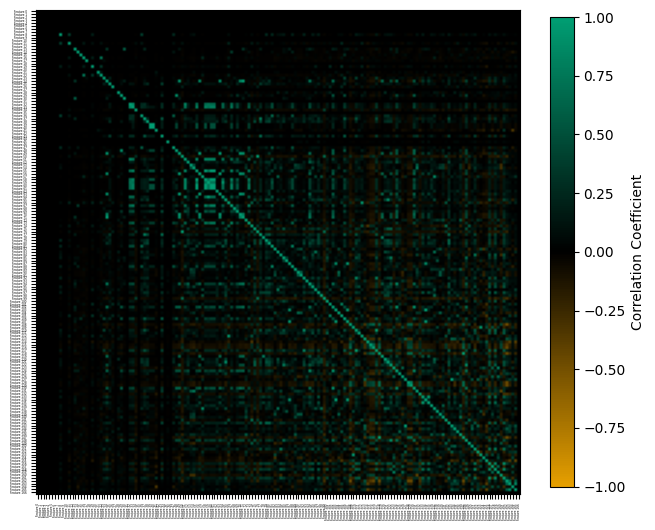

In [ ]:
# correlation matrix
FIGURE_WIDTH_LONG = 17.1 / 2.54

encoded_X_df = pd.DataFrame(encoded_X, columns=feature_names)
correlation_matrix = encoded_X_df.corr().fillna(0)

fig = plt.figure(figsize=(FIGURE_WIDTH_LONG, FIGURE_WIDTH_LONG))
plt.imshow(correlation_matrix, cmap=mycmap, vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient', shrink=0.73)
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90, fontsize=2)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names, fontsize=2)
# plt.title('Feature Correlation Matrix', fontsize=10)
plt.tight_layout()
print(fig.get_size_inches()*2.54)
plt.savefig('figures/feature_correlation_matrix.pdf', dpi=DPI)
plt.savefig('figures/feature_correlation_matrix.svg')
# plt.tick_params(labelbottom=False, labelleft=False)
# plt.xticks(ticks=[])
# plt.yticks(ticks=[])
plt.savefig('figures/feature_correlation_matrix.png', dpi=DPI)
plt.show()

#### Agglomerative Clustering

In [48]:
# Improved feature grouping using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [50]:
# Agglomerative clustering

correlation_matrix = pd.DataFrame(encoded_X_train_np).corr()
feature_variances = np.var(encoded_X_train_np, axis=0)
distance_matrix = 1 - np.abs(correlation_matrix.fillna(0))
correlation_threshold = 0.75
distance_threshold = 1 - correlation_threshold

clustering = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=distance_threshold,
    linkage='average', 
    metric='precomputed'
)

# Fit the clustering
cluster_labels = clustering.fit_predict(distance_matrix)

print(f"Agglomerative clustering created {clustering.n_clusters_} clusters")

# Create feature groups based on cluster labels
feature_groups = []
for cluster_id in range(clustering.n_clusters_):
    cluster_features = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    feature_groups.append(cluster_features)

# Select representative features for each group (highest variance)
selected_features_idx = []
selected_features_names = []
cluster_info = []

for group_id, feature_indices in enumerate(feature_groups):
    if len(feature_indices) > 1:
        # Multiple features in group - select the one with highest variance
        group_variances = [(idx, feature_names[idx], feature_variances[idx]) for idx in feature_indices]
        best_feature = max(group_variances, key=lambda x: x[2])
        selected_features_idx.append(best_feature[0])
        selected_features_names.append(best_feature[1])
        cluster_info.append({
            'cluster_id': group_id,
            'representative': best_feature[1],
            'members': [feature_names[idx] for idx in feature_indices],
            'size': len(feature_indices)
        })
    else:
        idx = feature_indices[0]
        name = feature_names[idx]
        selected_features_idx.append(idx)
        selected_features_names.append(name)
        cluster_info.append({
            'cluster_id': group_id,
            'representative': name,
            'members': [name],
            'size': 1
        })

print(f"Agglomerative clustering: Selected {len(selected_features_idx)} representative features")
print(f"Reduced from {len(feature_names)} to {len(selected_features_idx)} features ({100*(1-len(selected_features_idx)/len(feature_names)):.1f}% reduction)")

multi_member_groups = [c for c in cluster_info if c['size'] > 1]
print(f"\nAgglomerative clustering - Groups with multiple correlated features ({len(multi_member_groups)} groups):")
for group in sorted(multi_member_groups, key=lambda x: x['size'], reverse=True)[:15]:
    print(f"  Cluster {group['cluster_id']} ({group['size']} features): {group['representative']} represents {group['members']}{'...' if len(group['members']) > 5 else ''}")

print(f"\nComparison:")
print(f"Agglomerative: {len(selected_features_idx)} representative features, {len(multi_member_groups)} multi-member groups")

# Show cluster size distributions
agg_sizes = [c['size'] for c in cluster_info if c['size'] > 1]

print(f"\nCluster size statistics:")
print(f"Agglomerative - Max: {max(agg_sizes) if agg_sizes else 0}, Mean: {np.mean(agg_sizes) if agg_sizes else 0:.1f}, Median: {np.median(agg_sizes) if agg_sizes else 0:.1f}")

Agglomerative clustering created 127 clusters
Agglomerative clustering: Selected 127 representative features
Reduced from 167 to 127 features (24.0% reduction)

Agglomerative clustering - Groups with multiple correlated features (25 groups):
  Cluster 0 (8 features): Feature 67 represents ['Feature 32', 'Feature 33', 'Feature 51', 'Feature 55', 'Feature 58', 'Feature 60', 'Feature 61', 'Feature 67']...
  Cluster 11 (6 features): Feature 24 represents ['Feature 24', 'Feature 49', 'Feature 56', 'Feature 63', 'Feature 70', 'Feature 71']...
  Cluster 14 (4 features): Feature 103 represents ['Feature 87', 'Feature 103', 'Feature 107', 'Feature 134']
  Cluster 8 (3 features): Feature 117 represents ['Feature 92', 'Feature 110', 'Feature 117']
  Cluster 10 (3 features): Feature 124 represents ['Feature 102', 'Feature 124', 'Feature 130']
  Cluster 18 (3 features): Feature 161 represents ['Feature 156', 'Feature 158', 'Feature 161']
  Cluster 1 (2 features): Feature 123 represents ['Feature 12

In [59]:
groups_dict = { # representative: group
    'TPSA': 'Polarity',
    'MolWt': 'Weight and Shape',
    'NumAtomStereoCenters': 'Rings',
    'PEOE_VSA10': 'Alcohol Groups',
    'Kappa2': 'Branching'
    }

### Global SHAP feature importance

True
[8.3     4.66875]


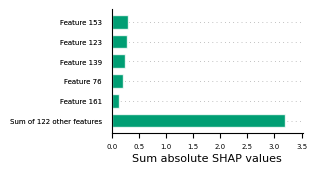

[8.3     4.66875]


In [63]:
import matplotlib.pyplot as plt
from utility.colors import okabe_ito
import matplotlib as mpl

bar_color = okabe_ito[3]

clustered_shap_values = np.zeros((shap_values.values.shape[0], len(feature_groups)))
for cluster_id, feature_indices in enumerate(feature_groups):
    clustered_shap_values[:, cluster_id] = np.sum(np.abs(shap_values.values[:, feature_indices]), axis=1)
clustered_shap = shap.Explanation(values=clustered_shap_values,
                                #  base_values=clustered_shap_values.mean(axis=0),
                                base_values=np.array([0.0]*len(feature_groups)),
                                 data=None,
                                 feature_names=selected_features_names)

fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH*0.75))
shap.plots.bar(clustered_shap,
                    show=False,
                    max_display=6,
                    )
ax = plt.gca()
for txt in list(ax.texts):
    try:
        txt.remove()
    except Exception:
        pass

patches = [p for p in ax.patches if isinstance(p, mpl.patches.Rectangle) and p.get_width() > 0]

num_bars = len(patches)
if num_bars > 0:
    for i, p in enumerate(patches):
        p.set_facecolor(bar_color)


y_tick_locs = ax.get_yticks()
y_tick_labels = [t.get_text() for t in ax.get_yticklabels()]
if not any('feature' in name.lower() for name in y_tick_labels):
    # For RDKit Descriptor names in study
    new_y_tick_labels = [groups_dict.get(name, name) for name in y_tick_labels] + [f'{133 - len(y_tick_labels)} other Groups']
    if len(new_y_tick_labels) == len(y_tick_labels) // 2:
        ax.set_yticklabels(2*new_y_tick_labels)


current_size = fig.get_size_inches()
new_width = FIGURE_WIDTH
scale_factor = new_width / current_size[0]
new_height = current_size[1] * scale_factor
fig.set_size_inches(new_width, new_height)
ax.set_xlabel('Sum absolute SHAP values', fontsize=FONTSIZE, labelpad=LABELPAD)
ax.tick_params(axis='both', which='major', labelsize=LABELSIZE)
print(fig.get_size_inches()*2.54)

plt.tight_layout()
plt.savefig('figures/shap_feature_importance.pdf', dpi=DPI)
plt.savefig('figures/shap_feature_importance.svg')
plt.savefig('figures/shap_feature_importance.png', dpi=DPI)
plt.show()

print(fig.get_size_inches()*2.54)


df_clustered_shap_values = pd.DataFrame(clustered_shap_values, columns=selected_features_names)

Most important feature group:
Representative feature: Feature 153
Cluster size: 2 features
All features in this cluster: ['Feature 109', 'Feature 153']


/tmp/ipykernel_2458039/2365493231.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(mycmap)


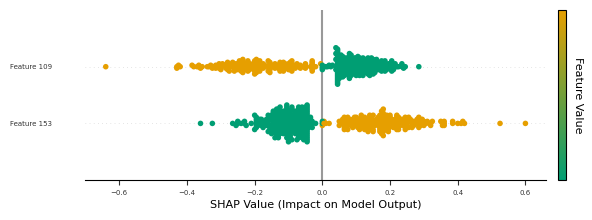

Most important feature group:
Representative feature: Feature 123
Cluster size: 2 features
All features in this cluster: ['Feature 123', 'Feature 159']


/tmp/ipykernel_2458039/2365493231.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(mycmap)


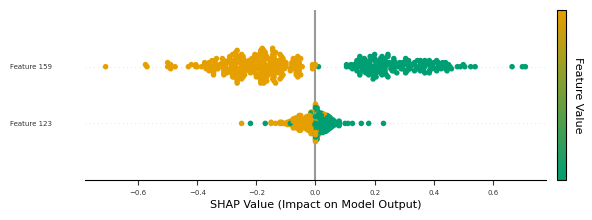

Most important feature group:
Representative feature: Feature 139
Cluster size: 1 features
All features in this cluster: ['Feature 139']


/tmp/ipykernel_2458039/2365493231.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(mycmap)


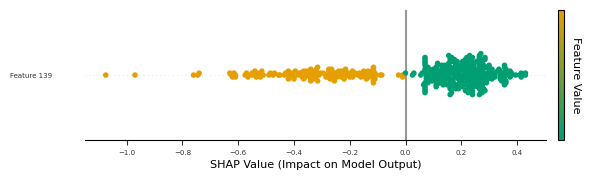

Most important feature group:
Representative feature: Feature 76
Cluster size: 2 features
All features in this cluster: ['Feature 50', 'Feature 76']


/tmp/ipykernel_2458039/2365493231.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(mycmap)


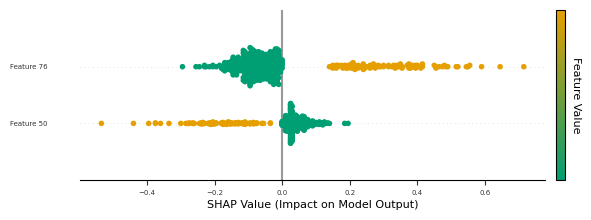

Most important feature group:
Representative feature: Feature 161
Cluster size: 3 features
All features in this cluster: ['Feature 156', 'Feature 158', 'Feature 161']


/tmp/ipykernel_2458039/2365493231.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(mycmap)


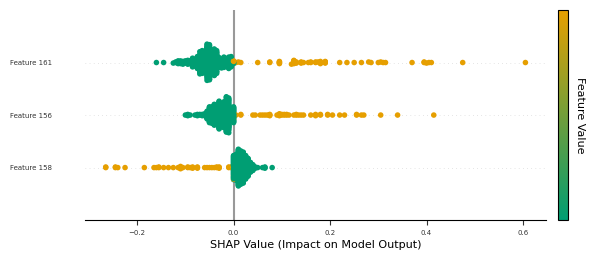

In [64]:
# Import matplotlib
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
colors = [okabe_ito[3], okabe_ito[1]]
mycmap = LinearSegmentedColormap.from_list("mycmap", colors, N=256)


def plot_summary_plot_feature_group(most_important_feature: str) -> None:
    """
    Create a SHAP summary plot for the most important feature group.
    
    This function generates a beeswarm plot showing SHAP values for all features
    within the most important feature groups, colored by feature values.
    
    Args:
        most_important_feature (str): Name of the representative feature for the cluster
        
    Returns:
        tuple: Representative feature name and list of cluster feature names
    """
    most_important_cluster = next(c for c in cluster_info if c['representative'] == most_important_feature)

    print(f"Most important feature group:")
    print(f"Representative feature: {most_important_cluster['representative']}")
    print(f"Cluster size: {most_important_cluster['size']} features")
    print(f"All features in this cluster: {most_important_cluster['members']}")
    most_important_cluster_indices = [i for i, name in enumerate(feature_names) if name in most_important_cluster['members']]
    cluster_shap_values = shap_values.values[:, most_important_cluster_indices]
    cluster_feature_values = encoded_X_test_np[:test_sample_size, most_important_cluster_indices]
    cluster_feature_names = [feature_names[i] for i in most_important_cluster_indices]
    cluster_shap_explanation = shap.Explanation(
        values=cluster_shap_values,
        base_values=shap_values.base_values,
        data=cluster_feature_values,
        feature_names=cluster_feature_names
    )

    fig =plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH*0.75))
    shap.plots.beeswarm(cluster_shap_explanation,
                        max_display=20,
                        show=False)
    cmap = mpl.cm.get_cmap(mycmap)

    ax = plt.gca()
    for coll in ax.collections:
        try:
            coll.set_cmap(cmap)
        except Exception:
            pass

    # update any image artists / colorbars if present
    for im in ax.get_images():
        try:
            im.set_cmap(cmap)
        except Exception:
            pass

    # redraw figure
    plt.draw()
    updated_cbar = False
    for coll in ax.collections:
        try:
            arr = coll.get_array()
            if arr is None or len(arr) == 0:
                continue
            norm = getattr(coll, "norm", None)
            mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            mappable.set_array(arr)

            for a in fig.axes[:]:
                if a is not ax:
                    pos = a.get_position()
                    if pos.width < 0.2 or pos.height < 0.2:
                        try:
                            fig.delaxes(a)
                        except Exception:
                            pass
            cbar = fig.colorbar(mappable, ax=ax, orientation="vertical", pad=0.02)
            cbar.set_label("Feature Value", rotation=270, labelpad=12, fontsize=FONTSIZE)
            # remove colorbar tick labels
            try:
                cbar.set_ticks([])
                cbar.ax.set_yticklabels([])
            except Exception:
                pass
            updated_cbar = True
            break
        except Exception:
            continue

    ax.set_xlabel('SHAP Value (Impact on Model Output)', fontsize=FONTSIZE, labelpad=LABELPAD)
    ax.tick_params(axis='both', which='major', labelsize=LABELSIZE)
    plt.tight_layout()
    plt.savefig(f'figures/shap_summary_plot_{most_important_cluster["representative"]}_cluster.pdf', dpi=DPI)
    plt.show()
    return most_important_feature, cluster_feature_names

important_features = []
representative_features = []

for representative_feature in y_tick_labels[:5]:
    rep_feature, cluster_features = plot_summary_plot_feature_group(representative_feature)
    representative_features.append(rep_feature)
    important_features.extend(cluster_features)

In [65]:
df_clusterd_shap_values_renamed = df_clustered_shap_values.rename(columns=lambda x: groups_dict.get(x, x))

category_colors = [okabe_ito[2], okabe_ito[3], okabe_ito[1], okabe_ito[7]]

preds_rounded = np.round(model.predict(X_test)).astype(int)

Feature 67     0.039010
Feature 123    0.270248
Feature 129    0.139703
Feature 77     0.001485
Feature 48     0.023911
dtype: float64
Feature 67     0.013929
Feature 123    0.363929
Feature 129    0.184643
Feature 77     0.002857
Feature 48     0.000000
dtype: float64
Feature 67     0.017708
Feature 123    0.270146
Feature 129    0.135479
Feature 77     0.001958
Feature 48     0.000000
dtype: float64
Feature 67     0.017319
Feature 123    0.307029
Feature 129    0.129710
Feature 77     0.001667
Feature 48     0.000000
dtype: float64


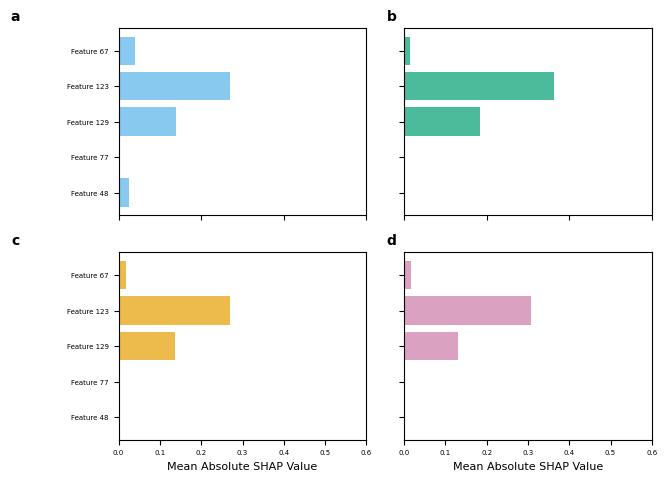

In [ ]:
# Create 2x2 subplot for each category showing mean SHAP values
fig, axes = plt.subplots(2, 2, figsize=(FIGURE_WIDTH_LONG, FIGURE_WIDTH*1.5))
axes = axes.flatten()

subplot_labels = ['a', 'b', 'c', 'd']
for i, category in enumerate([0, 1, 2, 3]):
    category_mask = preds_rounded == category
    category_shap_data = df_clusterd_shap_values_renamed[category_mask]
    # Check if all values from groups_dict are present in the columns
    if all(col in category_shap_data.columns for col in groups_dict.values()):
        mean_shap_values = category_shap_data[list(groups_dict.values())].mean(axis=0)
    else:
        mean_shap_values = category_shap_data.iloc[:,:5].mean(axis=0)
    bars = axes[i].barh(range(len(mean_shap_values)), mean_shap_values.values, color=category_colors[i], alpha=0.7)
    axes[i].set_xlim(0, 0.6)
    if i % 2 == 0:
        axes[i].set_yticks(range(len(mean_shap_values)))
        axes[i].set_yticklabels(mean_shap_values.index, fontsize=LABELSIZE)
    else:
        axes[i].set_yticks(range(len(mean_shap_values)))
        axes[i].set_yticklabels([])
    if i > 1:
        axes[i].set_xlabel('Mean Absolute SHAP Value', fontsize=FONTSIZE)
        axes[i].tick_params(axis='x', which='major', labelsize=LABELSIZE)
    else:
        axes[i].set_xticklabels([])
    axes[i].invert_yaxis()
    if i % 2 == 0:
        text_x = -0.4
    else:
        text_x = -0.03
    axes[i].text(text_x, 1.1, f'{subplot_labels[i]}', transform=axes[i].transAxes, 
        fontsize=FONTSIZE+2, fontweight='bold', ha='right', va='top')

plt.tight_layout()
plt.savefig('figures/shap_feature_importance_by_category.pdf', dpi=DPI)
plt.savefig('figures/shap_feature_importance_by_category.svg')
plt.savefig('figures/shap_feature_importance_by_category.png', dpi=DPI)
plt.show()

### Local Explanations

<>:87: SyntaxWarning: invalid escape sequence '\C'
<>:87: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipykernel_2458039/2831788137.py:87: SyntaxWarning: invalid escape sequence '\C'
  local_explain('CC(C)=CCC/C(C)=C\CC/C(C)=C/CO', background=encoded_X_train, save_path='figures/shap_local_explanation_ez_farnesol_group.svg', dpi=None)


SHAP values for molecule: OCCO


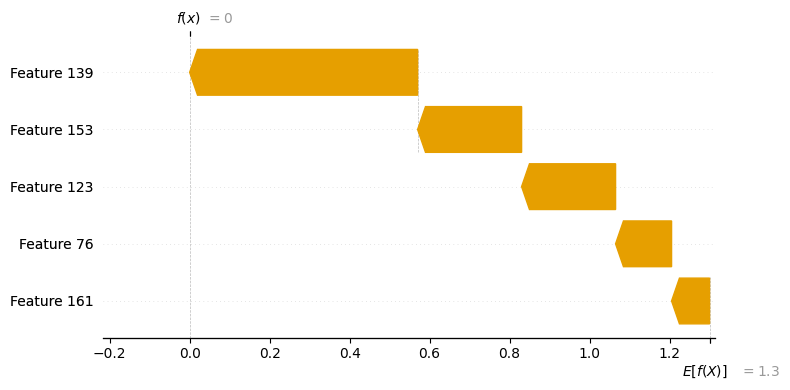

SHAP values for molecule: CC(C)=CCC/C(C)=C\CC/C(C)=C/CO


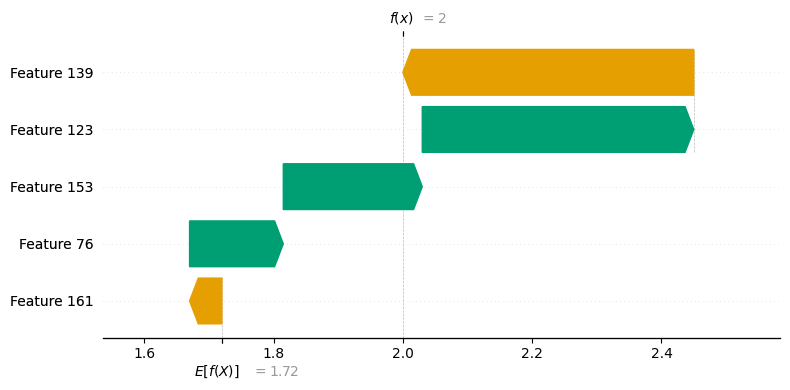

SHAP values for molecule: CC1COCc2cc3c(cc21)C(C)(C)C(C)C3(C)C	


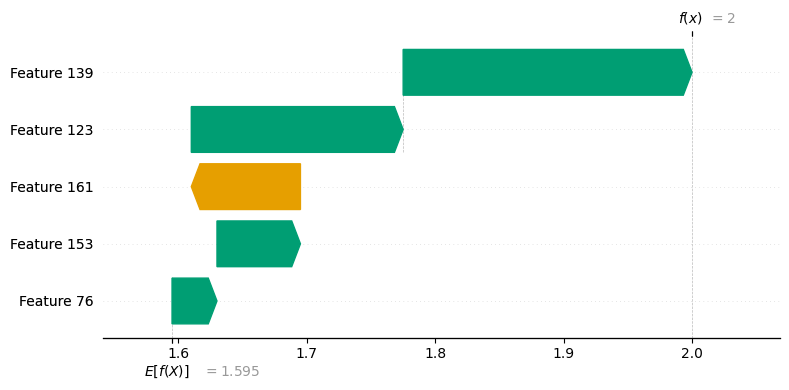

SHAP values for molecule: c1ccc2[nH]ccc2c1


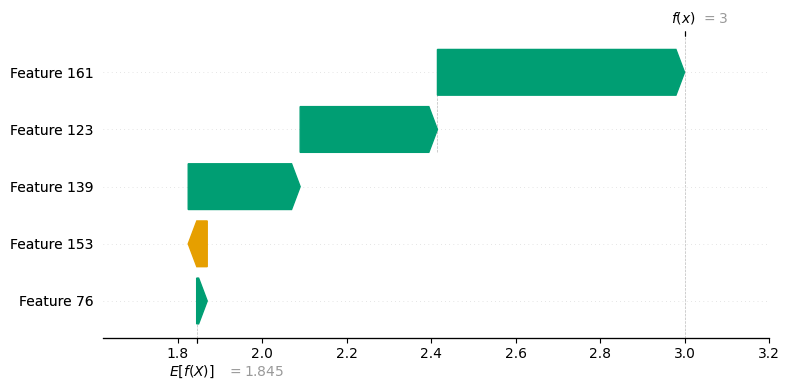

In [78]:
def local_explain(smiles: str, background: pd.DataFrame | np.ndarray, save_path: str | None = None, dpi: int = DPI) -> None:
    """
    Generate and visualize local SHAP explanations for individual molecules.
    
    This function creates a waterfall plot showing how each feature group contributes
    to the prediction for a specific molecule, starting from the base value.
    
    Args:
        smiles (str): SMILES string of the molecule to explain
        background (pd.DataFrame or np.ndarray): Background dataset for SHAP explainer
        save_path (str, optional): Path to save the visualization
        dpi (int): Resolution for saved figures
    """
    max_display = 6
    encoded_mol = model.odor_strength_module.molecule_encoder.encode([smiles])
    encoded_mol_np = encoded_mol.values if hasattr(encoded_mol, 'values') else encoded_mol
    background_values = background.values if hasattr(background, 'values') else background

    explainer = shap.Explainer(predictor_wrapper, background_values, feature_names=background.columns.tolist() if hasattr(background, 'columns') else None)
    shap_values_local = explainer(encoded_mol_np)
    clustered_shap_values = np.zeros((shap_values_local.values.shape[0], len(feature_groups)))
    for cluster_id, feature_indices in enumerate(feature_groups):
        clustered_shap_values[:, cluster_id] = np.sum(shap_values_local.values[:, feature_indices], axis=1)
    selected_clusters = pd.DataFrame(clustered_shap_values, columns=selected_features_names)
    selected_clusters = selected_clusters[representative_features]
    mapping = {
        'TPSA': 'Polarity',
        'MolWt': 'Weight and Shape',
        'NumAtomStereoCenters': 'Rings',
        'PEOE_VSA10': 'Alcohol Groups',
        'Kappa2': 'Branching',
    }
    selected_clusters.columns = [mapping.get(col, col) for col in selected_clusters.columns]
    other_clusters =  clustered_shap_values.sum() - selected_clusters.values.sum()
    clustered_shap_values = selected_clusters.values
    
    shap_values_clustered = shap.Explanation(values=clustered_shap_values,
                                    base_values=shap_values_local.base_values + other_clusters,
                                    data=None,
                                    feature_names=selected_clusters.columns.tolist())


    print(f"SHAP values for molecule: {smiles}")
    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH*0.75))
    shap.plots.waterfall(shap_values_clustered[0], max_display=max_display, show=False)
    for ax in fig.get_axes():
        for txt in list(ax.texts):
            txt.set_visible(False)
        for child in ax.get_children():
            if hasattr(child, 'get_text'):
                try:
                    child.set_visible(False)
                except:
                    pass
            elif hasattr(child, '__class__') and 'Arrow' in str(child.__class__):
                color = child.get_edgecolor()
                if color[0] == 1:
                    child.set_color(okabe_ito[3])
                else:
                    child.set_color(okabe_ito[1])
                pass
        
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    for ax in fig.get_axes():
        plt.setp(ax.get_xticklabels(), fontsize=LABELSIZE*2.25)
        plt.setp(ax.get_yticklabels(), fontsize=LABELSIZE*2.25)
        
        ax.tick_params(axis='both', which='major', labelsize=LABELSIZE*2.25)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=DPI)
    
    factor = 2
    for ax in fig.get_axes():
        plt.setp(ax.get_xticklabels(), fontsize=factor*LABELSIZE)
        plt.setp(ax.get_yticklabels(), fontsize=factor*LABELSIZE)
        ax.tick_params(axis='both', which='major', labelsize=factor*LABELSIZE)
    plt.tight_layout()
    plt.savefig(save_path.split('.')[0] + '.png', dpi=DPI)
    plt.show()
    

local_explain('OCCO', background=encoded_X_train, save_path='figures/shap_local_explanation_ethylene_glycol_group.svg', dpi=None)
local_explain('CC(C)=CCC/C(C)=C\CC/C(C)=C/CO', background=encoded_X_train, save_path='figures/shap_local_explanation_ez_farnesol_group.svg', dpi=None)
local_explain('CC1COCc2cc3c(cc21)C(C)(C)C(C)C3(C)C	', background=encoded_X_train, save_path='figures/shap_local_explanation_galaxolide_group.svg', dpi=None)
local_explain('c1ccc2[nH]ccc2c1', background=encoded_X_train, save_path='figures/shap_local_explanation_indole_group.svg', dpi=None)